In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import CubicSpline, lagrange
from scipy.optimize import curve_fit
from numpy.polynomial.polynomial import Polynomial
import random

## Make simple masks

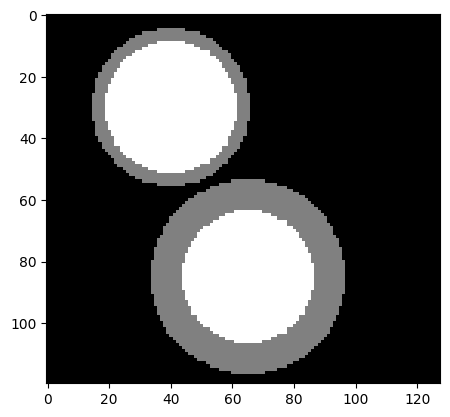

True

In [2]:
def simulate_bin_circle():
    image_hole = np.zeros((120, 128), dtype=np.float32)
    center_coordinates = (40, 30)
    center_coordinates2 = (65, 85)
    radius = 20

    color_border = (128, 0, 0)
    color_hole = (255, 0, 0)
    color = (191, 0, 0)
    
    thickness_border = -1
    thickness_hole = -1

    
    # image_border = cv2.circle(image_hole, center_coordinates, radius+2, color_border, thickness_border)

    image_border = cv2.circle(image_hole, center_coordinates, radius+4, color_border, 2)
    image_border = cv2.circle(image_border, center_coordinates, radius+4, color_border, thickness_border)
    image_hole = cv2.circle(image_border, center_coordinates, radius, color_hole,2)
    image_hole = cv2.circle(image_hole, center_coordinates, radius, color_hole, thickness_hole)

    
    image_border = cv2.circle(image_hole, center_coordinates2, radius+10, color_border, 2)
    image_border = cv2.circle(image_border, center_coordinates2, radius+10, color_border, -1)
    image_hole = cv2.circle(image_border, center_coordinates2, radius, color_hole, 2)
    image_hole = cv2.circle(image_hole, center_coordinates2, radius, color_hole, thickness_hole)

    plt.imshow(image_hole, cmap='gray')
    plt.show()
    return image_border

img = simulate_bin_circle()
img_large = img

circle2 = img_large.copy()

cv2.imwrite('input_crop_mask.png', np.clip(circle2, 0, 255))

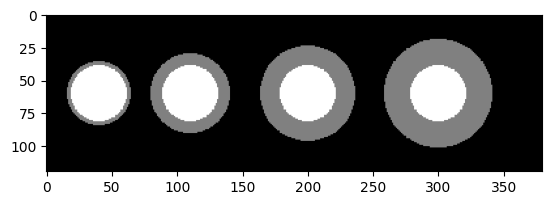

True

In [3]:
def simulate_circles():
    image_hole = np.zeros((120, 380), dtype=np.float32)
    center_coordinates1 = (40, 60)
    center_coordinates2 = (110, 60)
    center_coordinates3 = (200, 60)
    center_coordinates4 = (300, 60)

    radius = 20

    color_border = (128, 0, 0)
    color_hole = (255, 0, 0)
    
    thickness_border = -1
    thickness_hole = -1

    # border 3
    image_border = cv2.circle(image_hole, center_coordinates1, radius+3, color_border, 2)
    image_border = cv2.circle(image_border, center_coordinates1, radius+3, color_border, thickness_border)
    image_hole = cv2.circle(image_border, center_coordinates1, radius, color_hole,2)
    image_hole = cv2.circle(image_hole, center_coordinates1, radius, color_hole, thickness_hole)

    # border 9
    image_border = cv2.circle(image_hole, center_coordinates2, radius+9, color_border, 2)
    image_border = cv2.circle(image_border, center_coordinates2, radius+9, color_border, thickness_border)
    image_hole = cv2.circle(image_border, center_coordinates2, radius, color_hole,2)
    image_hole = cv2.circle(image_hole, center_coordinates2, radius, color_hole, thickness_hole)

    # border 15
    image_border = cv2.circle(image_hole, center_coordinates3, radius+15, color_border, 2)
    image_border = cv2.circle(image_border, center_coordinates3, radius+15, color_border, thickness_border)
    image_hole = cv2.circle(image_border, center_coordinates3, radius, color_hole,2)
    image_hole = cv2.circle(image_hole, center_coordinates3, radius, color_hole, thickness_hole)

    # border 20
    image_border = cv2.circle(image_hole, center_coordinates4, radius+20, color_border, 2)
    image_border = cv2.circle(image_border, center_coordinates4, radius+20, color_border, thickness_border)
    image_hole = cv2.circle(image_border, center_coordinates4, radius, color_hole,2)
    image_hole = cv2.circle(image_hole, center_coordinates4, radius, color_hole, thickness_hole)

    # print(np.unique(image_border))
    plt.imshow(image_hole, cmap='gray')
    plt.show()

    # cv2.imwrite('./data/test_img_two.png', image_border)
    return image_border

img_circles = simulate_circles()
cv2.imwrite('difr_circles.png', np.clip(img_circles, 0, 255))

## Смотрим на срезы сразу после маски

Text(0.5, 1.0, 'Сразу после маски горизонтальный срез')

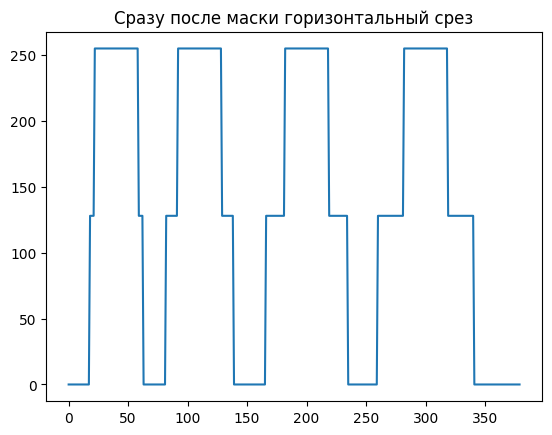

In [4]:
plt.plot(np.arange(0, img_circles.shape[1]), img_circles[50,:])
plt.title('Сразу после маски горизонтальный срез')

Text(0.5, 1.0, 'Сразу после маски вертикальный срез')

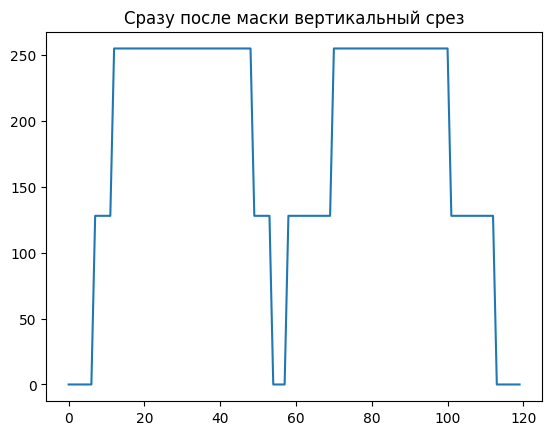

In [5]:
plt.plot(np.arange(0, circle2.shape[0]), circle2[:,50])
plt.title('Сразу после маски вертикальный срез')

## Считаем ширину границ

In [6]:
def get_edges_width(img):
    # mask_bord_bin = img == 128
    # mask_bord_bin = mask_bord_bin.astype(np.uint8)

    # rows, cols = img.shape

    # bord_mask = cv2.inRange(img, 128, 128)
    # bord_mask[bord_mask == 255] = 128
    bord_mask = img == 128
    bord_mask = bord_mask.astype(np.uint8)
    # bord_mask = bord_mask.astype(np.uint8)

    hole_mask = cv2.inRange(img, 255,255)
    rows, cols = img.shape
    dist_final = np.zeros_like(img)
    dist_y = np.zeros_like(img, dtype=np.float32)
    for col in range(0, cols):
        col_mask = bord_mask[:, col]
        nonzero_ind = np.nonzero(col_mask)[0]
        start_ind = np.where(np.diff(col_mask == 1))[0] + 1
        segments = np.split(col_mask, start_ind)
        tmp = 0 
        
        for segm in segments:
            dist_y[:, col][tmp:tmp + len(segm)] = (len(segm))
            tmp = tmp + len(segm)
    dist_x = np.zeros_like(img, dtype=np.float32)
    for row in range(0, rows):
        row_mask = bord_mask[row,:]
        nonzero_ind = np.nonzero(row_mask)[0]
        start_ind = np.where(np.diff(row_mask == 1))[0] + 1
        segments = np.split(row_mask, start_ind)
        tmp = 0 
        
        for segm in segments:
            dist_x[row, :][tmp:tmp + len(segm)] = (len(segm))
            tmp = tmp + len(segm)
    y = dist_y.copy()
    x = dist_x.copy()

    dist = np.zeros_like(dist_x,dtype=np.float32)
    dist[img == 128] = np.minimum(dist_x[img == 128], dist_y[img == 128])
    dist[img != 0] = np.minimum(dist_x[img != 0], dist_y[img != 0])

    # ___added____
    bord_mask = cv2.inRange(img, 128, 128)
    bord_mask[bord_mask == 255] = 128
    hole_mask = cv2.inRange(img, 255,255)
    hole_mask = hole_mask.astype(np.uint8)
    bord_mask = bord_mask.astype(np.uint8)
    for col in range(0, cols):
        # if col == 41:
        col_mask_bord = bord_mask[:,col]
        col_mask_hole = hole_mask[:,col]

        nonzero_ind_bord = np.nonzero(col_mask_bord)[0]
        nonzero_ind_hole = np.nonzero(col_mask_hole)[0]

        start_ind_bord = np.where(np.diff(col_mask_bord == 128))[0] + 1
        start_ind_hole = np.where(np.diff(col_mask_hole == 255))[0] + 1
        gray_segments = []
        segments= []
        for i in range(0, len(start_ind_bord), 2):
            gray_segments.append((start_ind_bord[i], start_ind_bord[i+1]))
        work_segments = []
        for segm in gray_segments:
            for i in segm:
                if i in start_ind_hole:
                    work_segments.append(segm)
        for segm in work_segments:
            # print(segm)
            dist_final[segm[0]:segm[1], col] = y[segm[0]:segm[1], col]


    for row in range(0, rows):
        # if row == 95:
        row_mask_bord = bord_mask[row,:]
        row_mask_hole = hole_mask[row,:]

        nonzero_ind_bord = np.nonzero(row_mask_bord)[0]
        nonzero_ind_hole = np.nonzero(row_mask_hole)[0]

        start_ind_bord = np.where(np.diff(row_mask_bord == 128))[0] + 1
        start_ind_hole = np.where(np.diff(row_mask_hole == 255))[0] + 1
        # print('start ind hole', start_ind_hole)
        gray_segments = []
        # white_segments_cols = []
        segments= []
        for i in range(0, len(start_ind_bord), 2):
            gray_segments.append((start_ind_bord[i], start_ind_bord[i+1]))
        
        work_segments = []
        for segm in gray_segments:
            for i in segm:
                if i in start_ind_hole:
                    work_segments.append(segm)
        
        for segm in work_segments:
            dist_final[row, segm[0]:segm[1]] = x[row, segm[0]:segm[1]]

    return dist

In [7]:
img_circles_edges_width = get_edges_width(img_circles)

### Получение карты углов

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

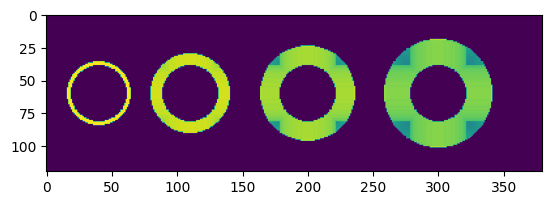

In [8]:
def get_edges_angles(img, edges_width):
    return np.arctan(700 / (edges_width[img == 128] * 12))

angles_edges_img_circles = np.zeros_like(img_circles, dtype=np.float32)
angles_edges_img_circles[img_circles==128] = get_edges_angles(img_circles, img_circles_edges_width)

plt.imshow(angles_edges_img_circles)
plt.plot

Text(0.5, 1.0, 'график карты углов в радианах, y=50')

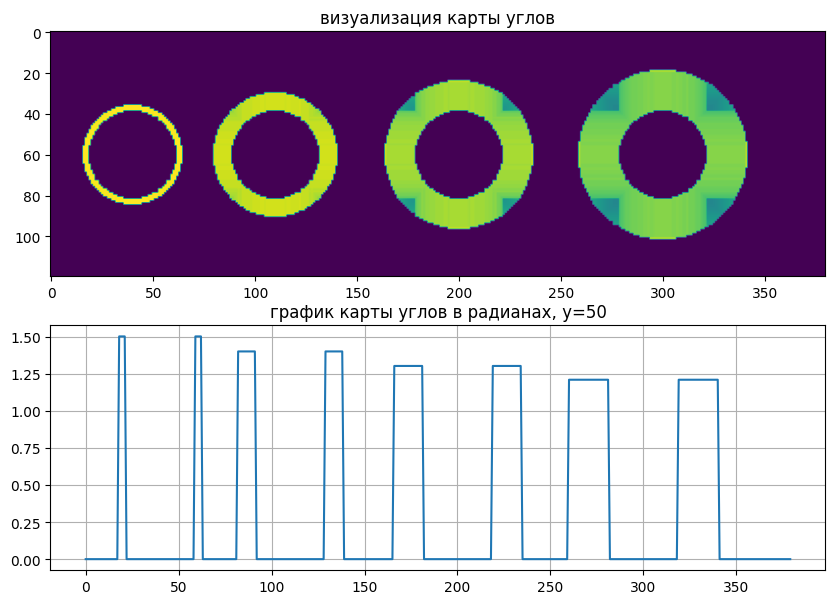

In [55]:
fig, ax = plt.subplots(2, 1, figsize=(10, 7))
y = 50
ax[0].imshow(angles_edges_img_circles)
ax[0].set_title('визуализация карты углов')
# ax[1].plot(np.arange(0, len(angles_edges_img_circles)), angles_edges_img_circles[:,45])
ax[1].plot(np.arange(0, angles_edges_img_circles.shape[1]), angles_edges_img_circles[y,:])

ax[1].grid()
ax[1].set_title(f'график карты углов в радианах, y={y}')

### Получение карты цветов

In [10]:
color_back = 120
color_hole = 90
color_edge = (color_back + color_hole)//2

[  0 255]


Text(0.5, 1.0, 'График карты углов, y=35')

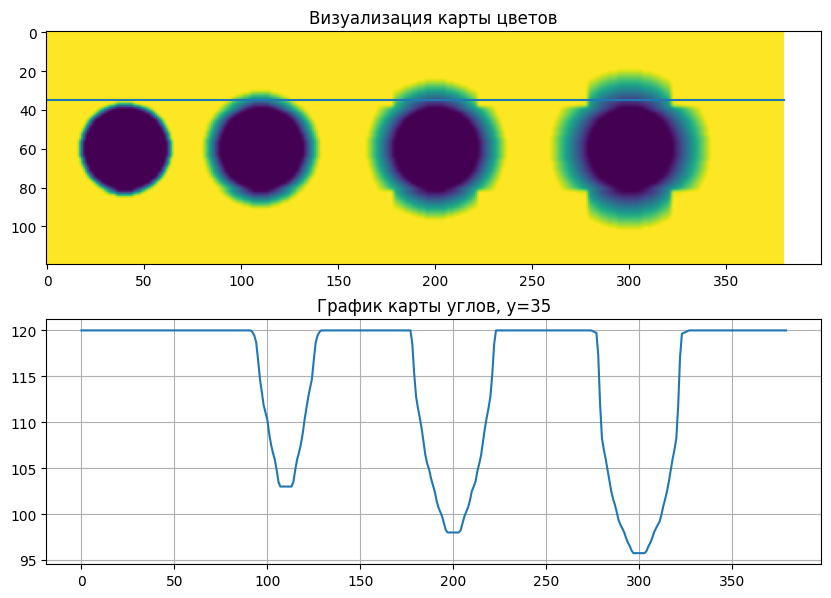

In [11]:
def get_color_map(img, color_back, color_hole):
    bord_mask = cv2.inRange(img, 128, 128)
    bord_mask[bord_mask == 255] = 128

    hole_mask = cv2.inRange(img, 255,255)
    print(np.unique(hole_mask))
    color_final = np.zeros_like(img)
    rows, cols = img.shape
    color_final[img == 0] = color_back # у фона цвет 100
    color_final[img == 255] = color_hole # у дна цвет 90

    for col in range(0, cols):
        col_mask_bord = bord_mask[:,col]
        col_mask_hole = hole_mask[:,col]
        start_ind_bord = np.where(np.diff(col_mask_bord == 128))[0] + 1
        start_ind_hole = np.where(np.diff(col_mask_hole == 255))[0] + 1
        gray_segments = []

        for i in range(0, len(start_ind_bord), 2):
            gray_segments.append((start_ind_bord[i], start_ind_bord[i+1]))
        
        work_segments = []
        other_segments = []
        for segm in gray_segments:
            for i in segm:
                if i in start_ind_hole:
                    work_segments.append(segm)
            if segm not in work_segments:
                other_segments.append(segm)

        for segm in work_segments:
            delta = segm[1] - segm[0]
            for i in (np.arange(segm[0], segm[1])):
                if img[segm[1]+1, col] < img[segm[0]-1, col]:
                    k = delta - (segm[1] - i)
                else:
                    k = delta - (np.abs(segm[0] - i))
                k_val = k * (color_back - color_hole) // delta + color_hole
                color_final[i, col] = k_val

        if (len(other_segments) != 0) and (len(gray_segments) != 0):
            # print('no hole here')
            # print(gray_segments, other_segments)
            for segment in other_segments:
                delta = segment[1] - segment[0]
                segm1 = (segment[0], segment[0] + delta//2)
                segm2 = (segment[0] + delta//2, segment[1])

                for segm in [segm1, segm2]:
                    # print(segm)
                    for i in (np.arange(segm[0], segm[1])):
                        if img[segm[1]+1, col] > img[segm[0]-1, col]:
                            # print('>')
                            k = delta//2 - (segm[1] - i)
                        else:
                            k = delta//2 - (np.abs(segm[0] - i))
                        k_val = color_back - k * (color_back - color_edge) // delta//2
                        # print(k_val)
                        color_final[i, col] = k_val       

    for row in range(0, rows):
        row_mask_bord = bord_mask[row,:]
        row_mask_hole = hole_mask[row,:]

        start_ind_bord = np.where(np.diff(row_mask_bord == 128))[0] + 1
        start_ind_hole = np.where(np.diff(row_mask_hole == 255))[0] + 1
        gray_segments = []
        for i in range(0, len(start_ind_bord), 2):
            gray_segments.append((start_ind_bord[i], start_ind_bord[i+1]))
        
        work_segments = []
        other_segments = []
        for segm in gray_segments:
            for i in segm:
                if i in start_ind_hole:
                    work_segments.append(segm)
            if segm not in work_segments:
                other_segments.append(segm)

        for segm in work_segments:
            delta = segm[1] - segm[0]
            for i in (np.arange(segm[0], segm[1]+1)):
                
                if img[row, segm[1]+1] < img[row, segm[0]-1]:
                    k = delta - (segm[1] - i)
                else:
                    k = delta - (np.abs(segm[0] - i))
                k_val = k * (color_back - color_hole) // delta + color_hole
                color_final[row, i] = k_val
    # mask = img==128
    color_final = cv2.GaussianBlur(color_final, (3, 3), 0)
    return color_final

color_map = get_color_map(img_circles, color_back, color_hole)
fig, ax = plt.subplots(2, 1, figsize=(10, 7))
y = 35
x = 170
ax[0].imshow(color_map)
ax[0].plot([0, color_map.shape[1]], [y, y])
ax[0].set_title('Визуализация карты цветов')

ax[1].plot(np.arange(0, color_map.shape[1]), color_map[y,:])
# ax[1].plot(np.arange(0, color_map_new.shape[0]), color_map_new[:,x])


ax[1].grid()
ax[1].set_title(f'График карты углов, y={y}')


### Аппроксимация карты углов

In [12]:
def parabola(x, a, b, c):
    return a*x**2 + b*x + c

8
8
7
7
6
6
5
4
5
5
4
4
4
4
4
4
4
4
4
4
3
3
4
4
3
3
4
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
3
3
4
4
3
3
3
3
4
4
4
4
4
4
4
4
5
5
5
4
6
6
7
7
8
8
18
18
15
15
14
14
13
12
13
13
11
11
11
11
11
11
11
11
11
11
10
10
10
10
10
10
10
10
9
9
9
9
10
10
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
10
10
9
9
9
9
10
10
10
10
10
10
10
10
9
9
11
11
11
11
11
11
11
11
13
13
13
12
14
14
15
15
18
18
26
26
23
23
22
22
20
19
20
20
18
18
18
18
17
17
17
17
17
17
16
16
16
16
16
16
16
16
15
15
15
15
16
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
16
15
15
15
15
16
16
16
16
16
16
16
16
16
16
17
17
17
17
18
18
18
18
20
20
20
19
22
22
23
23
26
26
31
31
29
29
27
27
26
25
25
25
24
24
23
23
23
23
23
23
22
22
22
22
22
22
21
21
21
21
20
20
21
21
21
21
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
21
21
21
21
20
20
21
21
21
21
22
22
22
22
21
21
23
23
23
23
23
23
24
24
25
25
26
25
27
27
29
29
31
31


Text(0.5, 1.0, 'График карты углов, y=50')

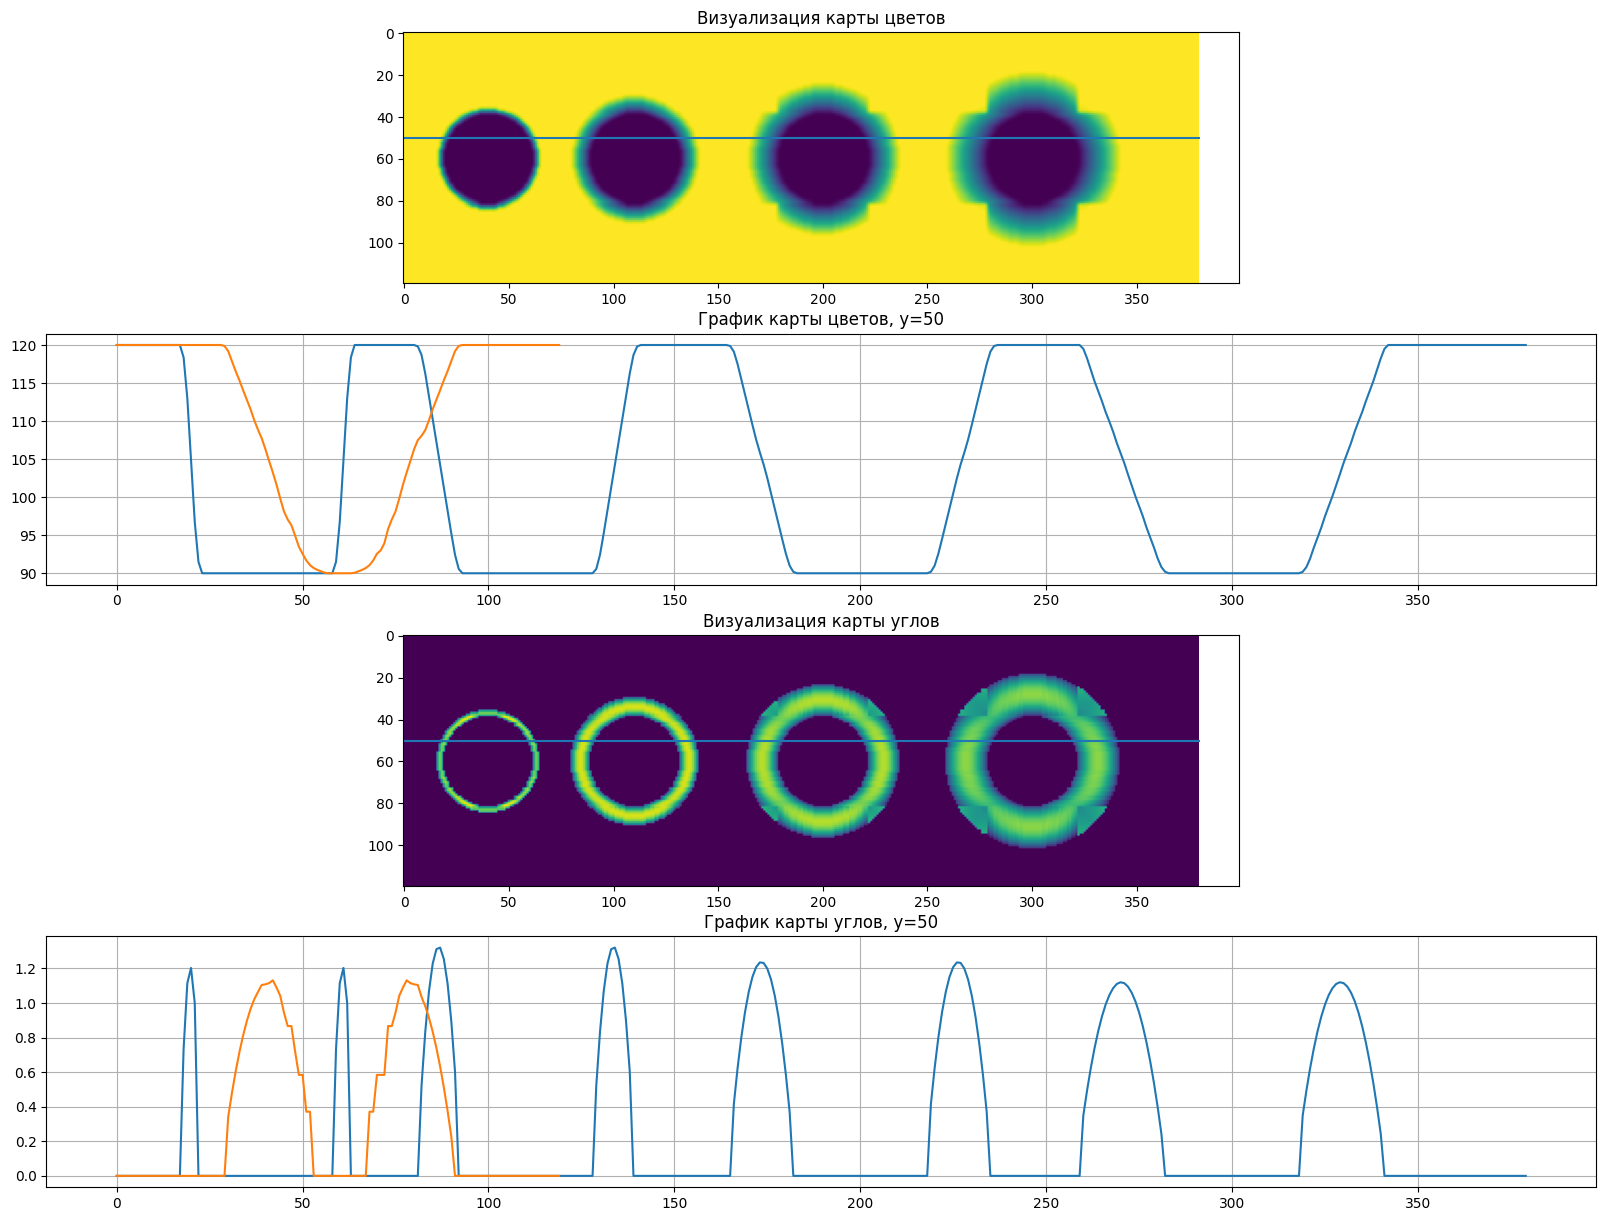

In [88]:
def get_colors_angles(img, angles_edges, color_back, color_hole):
    bord_mask = cv2.inRange(img, 128, 128)
    bord_mask[bord_mask == 255] = 128

    hole_mask = cv2.inRange(img, 255,255)
    color_final = np.zeros_like(img)
    angles_final = angles_edges.copy()
    # angles_final = np.zeros_like(img)
    rows, cols = img.shape
    color_final[img == 0] = color_back # у фона цвет 100
    color_final[img == 255] = color_hole # у дна цвет 90

    for col in range(0, cols):
        col_mask_bord = bord_mask[:,col]
        col_mask_hole = hole_mask[:,col]
        start_ind_bord = np.where(np.diff(col_mask_bord == 128))[0] + 1
        start_ind_hole = np.where(np.diff(col_mask_hole == 255))[0] + 1
        gray_segments = []

        for i in range(0, len(start_ind_bord), 2):
            gray_segments.append((start_ind_bord[i], start_ind_bord[i+1]))
        
        work_segments = []
        other_segments = []
        for segm in gray_segments:
            for i in segm:
                if i in start_ind_hole:
                    work_segments.append(segm)
            if segm not in work_segments:
                other_segments.append(segm)
            delta = segm[1] - segm[0]
            # angles_final[segm[0]:segm[1], col] = angles_edges[segm[0]:segm[1], col]

        for segm in work_segments:
            delta = segm[1] - segm[0]
            print(delta)
            for i in (np.arange(segm[0], segm[1])):
                if img[segm[1]+1, col] < img[segm[0]-1, col]:
                    k = delta - (segm[1] - i)
                else:
                    k = delta - (np.abs(segm[0] - i))
                k_val = k * (color_back - color_hole) // delta + color_hole
                color_final[i, col] = k_val

            if delta >= 3:
                ind_mean = segm[0] + delta // 2
                y_mean_lagrange = angles_edges[ind_mean, col]

                y_0 = angles_edges[segm[0], col]/2
                y_n = angles_edges[segm[1], col]/2
                
                x_1 = segm[0] - 1
                x_2 = segm[1] + 1

                y_1 = angles_edges[x_1, col]
                y_2 = angles_edges[x_2, col]

                # if delta < 4:
                #     coef = 0
                # else:
                coef = delta/10
                y_mean_lagrange = y_mean_lagrange - coef*0.05
                y_0_ = y_0 - coef*0.02
                y_n_ = y_n - coef*0.02

                coefs = curve_fit(parabola, [x_1, segm[0], ind_mean, segm[1], x_2], [y_1, y_0_, y_mean_lagrange, y_n_, y_2])
                a,b,c = coefs[0]
                
                x_for_plot = np.arange(segm[0], segm[1])
                y_parabola = parabola(x_for_plot, a, b, c)
                angles_final[segm[0]:segm[1], col] = y_parabola
            # else:
            #     angles_final[segm[0]:segm[1], col] = angles_edges[segm[0]:segm[1], col]


        if (len(other_segments) != 0) and (len(gray_segments) != 0):
            for segment in other_segments:
                delta = segment[1] - segment[0]
                segm1 = (segment[0], segment[0] + delta//2)
                segm2 = (segment[0] + delta//2, segment[1])

                for segm in [segm1, segm2]:
                    for i in (np.arange(segm[0], segm[1])):
                        if img[segm[1]+1, col] > img[segm[0]-1, col]:
                            k = delta//2 - (segm[1] - i)
                        else:
                            k = delta//2 - (np.abs(segm[0] - i))
                        k_val = color_back - k * (color_back - color_edge) // delta//2
                        color_final[i, col] = k_val       

    for row in range(0, rows):
        row_mask_bord = bord_mask[row,:]
        row_mask_hole = hole_mask[row,:]

        start_ind_bord = np.where(np.diff(row_mask_bord == 128))[0] + 1
        start_ind_hole = np.where(np.diff(row_mask_hole == 255))[0] + 1
        gray_segments = []
        for i in range(0, len(start_ind_bord), 2):
            gray_segments.append((start_ind_bord[i], start_ind_bord[i+1]))
        
        work_segments = []
        other_segments = []
        for segm in gray_segments:
            for i in segm:
                if i in start_ind_hole:
                    work_segments.append(segm)
            if segm not in work_segments:
                other_segments.append(segm)
            delta = segm[1] - segm[0]
            # angles_final[row, segm[0]:segm[1]] = angles_edges[row, segm[0]:segm[1]]

        for segm in work_segments:
            delta = segm[1] - segm[0]
            for i in (np.arange(segm[0], segm[1]+1)):
                
                if img[row, segm[1]+1] < img[row, segm[0]-1]:
                    k = delta - (segm[1] - i)
                else:
                    k = delta - (np.abs(segm[0] - i))
                k_val = k * (color_back - color_hole) // delta + color_hole
                color_final[row, i] = k_val

            if delta >= 3:
                ind_mean = segm[0] + delta // 2
                y_mean_lagrange = angles_edges[row, ind_mean]

                y_0 = angles_edges[row, segm[0]]/2
                y_n = angles_edges[row, segm[1]]/2
                
                x_1 = segm[0] - 1
                x_2 = segm[1] + 1

                y_1 = angles_edges[row, x_1]
                y_2 = angles_edges[row, x_2]

                coef = delta/10
                y_mean_lagrange = y_mean_lagrange - coef*0.05
                y_0_ = y_0 - coef*0.02
                y_n_ = y_n - coef*0.02

                coefs = curve_fit(parabola, [x_1, segm[0], ind_mean, segm[1], x_2], [y_1, y_0_, y_mean_lagrange, y_n_, y_2])
                a,b,c = coefs[0]
                
                x_for_plot = np.arange(segm[0], segm[1])
                y_parabola = parabola(x_for_plot, a, b, c)
                angles_final[row, segm[0]:segm[1]] = y_parabola
            # else:
            #     angles_final[row, segm[0]:segm[1]] = angles_edges[row, segm[0]:segm[1]]

    color_final = cv2.GaussianBlur(color_final, (3, 3), 0)
    # angles_final = cv2.GaussianBlur(angles_final, (3, 3), 0)
    return color_final, angles_final

color_map_new, angles_final = get_colors_angles(img_circles, angles_edges_img_circles, color_back, color_hole)
fig, ax = plt.subplots(4, 1, figsize=(20, 15))
y = 50
x = 180
ax[0].imshow(color_map_new)
ax[0].plot([0, color_map_new.shape[1]], [y, y])
ax[0].set_title('Визуализация карты цветов')

ax[1].plot(np.arange(0, color_map_new.shape[1]), color_map_new[y,:])
ax[1].plot(np.arange(0, color_map_new.shape[0]), color_map_new[:,x])
ax[1].grid()
ax[1].set_title(f'График карты цветов, y={y}')

ax[2].imshow(angles_final)
ax[2].plot([0, angles_final.shape[1]], [y, y])
ax[2].set_title('Визуализация карты углов')

ax[3].plot(np.arange(0, angles_final.shape[1]),angles_final[y,:])
ax[3].plot(np.arange(0, angles_final.shape[0]), angles_final[:,x])


ax[3].grid()
ax[3].set_title(f'График карты углов, y={y}')


### Разные формулы сигнала

#### Формула №1

mean back 42.711613
mean hole 49.208435
mean bord 27.958418
MIN bord 25.003313
mean color bord:  106.83742
MAX value:  226.24031
MIN value:  115.00419


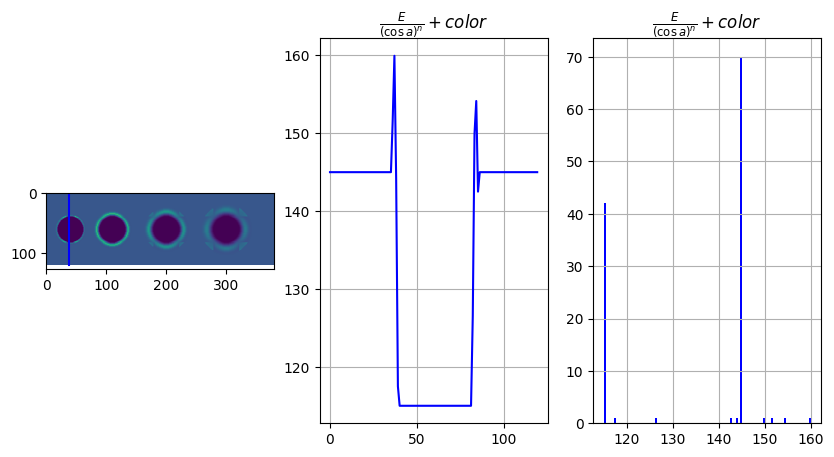

In [89]:
def formula_first(img, angles, color_map, E):
    signal = np.zeros_like(img, dtype=np.float32)

    alpha_bord = angles[img == 128]
    alpha_bord[alpha_bord==alpha_bord.min()] = np.radians(1)

    alpha_back = angles[img == 0]
    alpha_hole = angles[img == 255]

    print('mean back', np.mean(E / np.abs(np.cos(alpha_back + 1))**(0.87)))
    print('mean hole', np.mean(E / np.abs(np.cos(alpha_hole + 1))**(1.1)))
    print('mean bord', np.mean((E / np.abs(np.cos(alpha_bord)))**(0.87)))
    print('MIN bord', (E / np.abs(np.cos(np.radians(90)-(np.radians(180 - 90) - alpha_bord)))**(0.87)).min())
    print('mean color bord: ', np.mean(color_map[img==128]))

    # signal[crop == 0] =  E / np.cos(alpha_back + 1)**(0.87) + 100
    signal[img == 0] =  (E / (np.abs(np.cos(np.radians(alpha_back + 1)))**(0.87))) + color_map[img==0]

    # signal[crop == 128] = E / np.cos(np.radians(90)-(np.radians(180 - 90) - alpha_bord))**(0.87) + 120
    # signal[crop == 128] = E / np.abs(np.cos(np.radians(90) - alpha_bord))**(0.87) + color_map[crop==128]
    signal[img == 128] = (E / (np.abs(np.cos(np.radians(90) - (np.radians(180 - 90) - alpha_bord)))**(0.87))) + color_map[img==128]


    # signal[crop == 255] = E / np.cos(alpha_hole + 1)**(1.1) + 60
    signal[img == 255] = (E / (np.abs(np.cos(np.radians(alpha_hole + 1)))**(1.1))) + color_map[img==255]

    signal = np.clip(signal, 0, 255)
    cv2.imwrite(f'./data/out/var1_img_circles3_E{E}.png', signal.astype(np.uint8))


    return signal

signal_first = formula_first(img_circles, angles_final, color_map_new, E=25)


fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(signal_first)
ax[0].plot([38, 38], [0, signal_first.shape[0]], color='blue')

ax[1].plot(signal_first[:, 38], color='blue')
ax[1].grid()
ax[1].set_title(r'$\frac{E}{(\cos a)^n} + color$')


ax[2].hist(signal_first[:, 38], color='blue', bins=100)
ax[2].grid()
ax[2].set_title(r'$\frac{E}{(\cos a)^n} + color$')


print('MAX value: ', signal_first.ravel().max())
print('MIN value: ', signal_first.ravel().min())
